In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tda.common.measurement import Measurement

from tda.sim.sim_engine import Simulation
from tda.sim.sim_objects.lti_object import LTIObject
from tda.sim.sensors import clutter_model

from tda.sim.sensors.oracle import Oracle

from tda.tracker.filters.linear_kalman import LinearKalman
from tda.tracker.track import Track
from tda.tracker.tracker import Tracker
from tda.tracker.tracker_param import TrackerParam

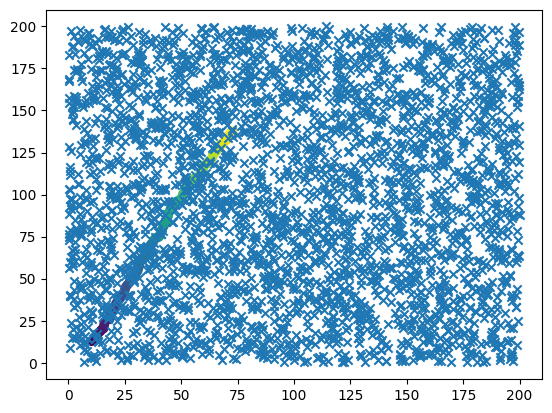

In [3]:
sim = Simulation()

extent = np.array([[-50, -50, -1],
                   [150, 150, 10]]).T

platform = LTIObject(1, np.array([50, 50, 0]), sim, np.zeros((3, 3)))
oracle = Oracle(1, platform, 2.0, np.eye(3) * 2.25, prob_detect=1.0, field_of_regard=extent)
oracle.add_clutter_model(clutter_model.PoissonClutter(oracle, 100))
platform.add_payload(oracle)

target_Q = np.zeros((6, 6))
target_Q[0, 0] = 0.25
target_Q[1, 1] = 0.33

target = LTIObject(2, np.array([10, 12, 0, 1, 2, 0]), sim, target_Q)

sim._sim_objects.extend([platform, target])

sim_records = sim.run()

plt.scatter(sim_records["lti_object2"]["x"], sim_records["lti_object2"]["y"], c=sim_records["lti_object2"]["t"])
plt.scatter(sim_records["oracle1"]["target_x"] + sim_records["oracle1"]["sensor_x"], sim_records["oracle1"]["target_y"] + sim_records["oracle1"]["sensor_y"], marker="x")

In [4]:
def F(dt: float):
    F = np.eye(6, dtype=np.float64)
    F[0, 3] = F[1, 4] = F[2, 5] = dt

    return F

def Q(dt: float):
    Q = np.zeros((6, 6))
    Q[0, 0] = 0.35
    Q[1, 1] = 0.35

    return dt * Q

H = np.array([[1, 0, 0, 1, 0, 0],
              [0, 1, 0, 0, 1, 0],
              [0, 0, 1, 0, 0, 1]])

def hinv(y):
    return np.array([y[0], y[1], y[2], 0, 0, 0])

R = 3 * np.eye(3)

def lkf_factory(meas: Measurement) -> Track:
    x0_hat = hinv(meas.y)
    P0_hat = np.eye(6) * 1e9

    return LinearKalman(x0_hat, P0_hat, F, H, Q, R)

In [4]:
tracker_params = TrackerParam(associator_type="truth",
                              initeator_type="truth",
                              deletor_type="truth",
                              filter_factory=lkf_factory)

tracker = Tracker(tracker_params)

In [6]:
for frame in sim.meas_queue:
    tracker.process_frame(frame)

kf_record = tracker.tracks[0].filter.record()

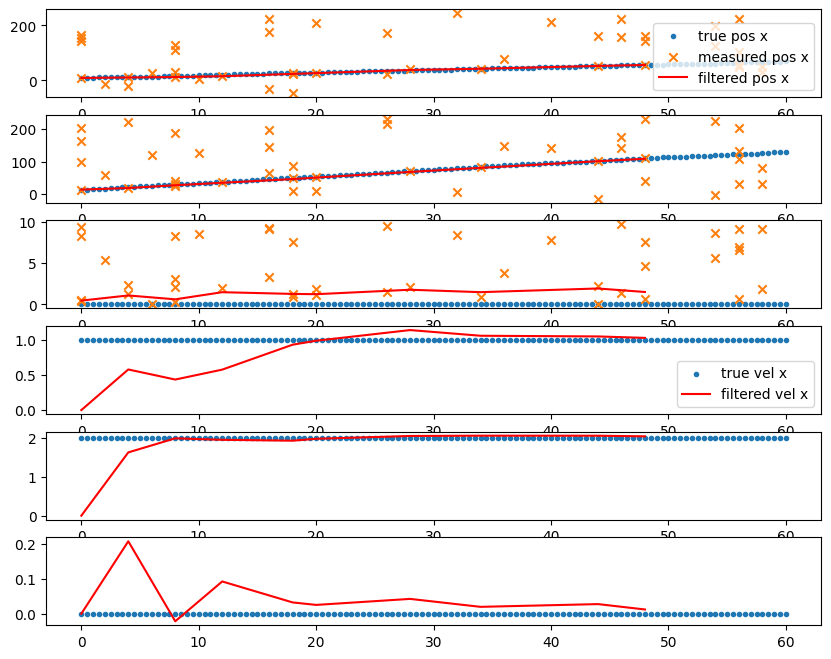

In [6]:
fig, axs = plt.subplots(6)
fig.set_size_inches((10, 8))
axs[0].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["x"], marker=".", label="true pos x")
axs[0].scatter(sim_records["oracle1"]["t"], sim_records["lti_object1"]["x"][0] \
               + sim_records["oracle1"]["target_x"], marker="x", label="measured pos x")
axs[0].plot(kf_record["t"], sim_records["lti_object1"]["x"][0] \
            + kf_record["x_hat"][:, 0], color="red", label="filtered pos x")
axs[0].legend()

axs[1].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["y"], marker=".", label="true pos y")
axs[1].scatter(sim_records["oracle1"]["t"], sim_records["lti_object1"]["y"][0] \
               + sim_records["oracle1"]["target_y"], marker="x", label="measured pos y")
axs[1].plot(kf_record["t"], sim_records["lti_object1"]["y"][0] \
            + kf_record["x_hat"][:, 1], color="red", label="filtered pos y")

axs[2].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["z"], marker=".", label="true pos z")
axs[2].scatter(sim_records["oracle1"]["t"], sim_records["oracle1"]["target_z"], marker="x", label="measured pos z")
axs[2].plot(kf_record["t"], kf_record["x_hat"][:, 2], color="red", label="filtered pos z")

axs[3].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["xdot"], marker=".", label="true vel x")
axs[3].plot(kf_record["t"], kf_record["x_hat"][:, 3], color="red", label="filtered vel x")
axs[3].legend()

axs[4].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["ydot"], marker=".", label="true vel y")
axs[4].plot(kf_record["t"], kf_record["x_hat"][:, 4], color="red", label="filtered pos y")

axs[5].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["zdot"], marker=".", label="true vel z")
axs[5].plot(kf_record["t"], kf_record["x_hat"][:, 5], color="red", label="filtered pos z")

In [5]:
tracker_params = TrackerParam(associator_type="pda",
                              initeator_type="pda",
                              deletor_type="truth",
                              filter_factory=lkf_factory)

tracker = Tracker(tracker_params)

In [6]:
for frame in sim.meas_queue:
    tracker.process_frame(frame)

kf_record = tracker.tracks[0].filter.record()

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)